In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt

import suncal
sympy.init_printing()  # And show sympy in rendered format

# Instrumentation amplifier

Problem: Choose resistors to minimize the uncertainty of the amplifier gain.

(Ref: Figure 5-12 in Thackray, Electronic Design)

![Amplifier](inst_amp.png)

The textbook equation for gain is $-\frac{R_4}{R_3}(1+\frac{2 R_2}{R_1})$. However, the resistor pairs (e.g. both $R_2$'s) will not be identical, but pulled from the same distribution. We need to re-derive the gain expression keeping the resistor pairs separate. Instead of doing a bunch of ugly algebra, we can set up the current equations and use Sympy to solve the system.

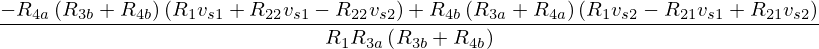

In [2]:
vs1, vs2, vo1, vo2 = sympy.symbols(['v_s1', 'v_s2', 'v_o1','v_o2'])
R22, R21, R3a, R3b, R4a, R4b = sympy.symbols(['R_21', 'R_22', 'R_3a','R_3b','R_4a','R_4b'])
a3, vo, R1, R2, R3, R4 = sympy.symbols(['a3', 'vo', 'R_1', 'R_2','R_3', 'R_4'])
eqn1 = sympy.Eq((vo1-a3)/R3a, (a3-vo)/R4a)
eqn2 = sympy.Eq((vo2-a3)/R3b,  a3/R4b)
eqn3 = sympy.Eq((vo1-vs1)/R21, (vs1-vs2)/R1)
eqn4 = sympy.Eq((vo2-vs2)/R22, (vs2-vs1)/R1)
vout = sympy.solve((eqn1, eqn2, eqn3, eqn4), (a3,vo1,vo2,vo))
vout = vout[vo].simplify()
vout

Double check: if the resistor pairs are equal (R_1a == R1b, etc), the expression should reduce to $-\frac{R_4}{R_3}(1+\frac{2 R_2}{R_1})(v_{s1}-v_{s2})$.

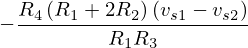

In [3]:
vout_simp = vout.subs({'R_3a':R3,'R_3b':R3,'R_4a':R4,'R_4b':R4, 'R_22':R2, 'R_21':R2}).factor()
vout_simp

Now that we have our expression, send it in to the calculator. Make up some resistor values, and start with all 5% tolerance. This is assuming that 5% is normally distributed, which may or may not be valid... Print the sensitivity coefficients to see which has the most influence.

In [4]:
inputs = [{'name':'R_1', 'nom':10000, 'uncerts':[{'name':'uR1',   'std':'5%'}]},
          {'name':'R_21', 'nom':47000, 'uncerts':[{'name':'uR21', 'std':'5%'}]},
          {'name':'R_22', 'nom':47000, 'uncerts':[{'name':'uR22', 'std':'5%'}]},
          {'name':'R_3a', 'nom':22000, 'uncerts':[{'name':'uR31', 'std':'5%'}]},
          {'name':'R_3b', 'nom':22000, 'uncerts':[{'name':'uR3b', 'std':'5%'}]}, 
          {'name':'R_4a', 'nom':22000, 'uncerts':[{'name':'uR4a', 'std':'5%'}]},
          {'name':'R_4b', 'nom':22000, 'uncerts':[{'name':'uR4b', 'std':'5%'}]},
          {'name':'v_s1', 'nom':.010,  'uncerts':[{'name':'uvs1', 'std':'1E-6'}]},
          {'name':'v_s2', 'nom':-.010, 'uncerts':[{'name':'uvs2', 'std':'1E-6'}]}]         
u = suncal.UncertCalc(vout, inputs=inputs)
u.set_function(vout, idx=0, name='vout', show=False) # Set name and disable reporting
u.set_function('vout/(v_s1-v_s2)', name='gain')
u.calculate()
u.out.report_sens()

$gain = \frac{vout}{v_{s1} - v_{s2}}$


Variable   | GUM Sensitivity   | GUM Proportion   | MC Sensitivity   | MC Proportion  
----------|-----------------|----------------|----------------|---------------
$R_{1}$   | 0.00094           | 33.00%           | 0.00095          | 32.99%         
$R_{21}$   | -0.00010           | 8.25%            | 0.000100          | 8.07%          
$R_{22}$   | -0.00010           | 8.25%            | 0.000100          | 8.08%          
$R_{3a}$   | 0.00035           | 22.72%           | 0.00036          | 22.72%         
$R_{3b}$   | 0.00012           | 2.52%            | 0.00012          | 2.49%          
$R_{4a}$   | -0.00035          | 22.72%           | 0.00035         | 22.24%         
$R_{4b}$   | -0.00012          | 2.52%            | 0.00012         | 2.49%          
$v_{s1}$   | 0.0          | 0.00%            | 5.9e-09         | 0.00%          
$v_{s2}$   | 0.0          | 0.00%            | 5.9e-09         | 0.00%

R1 is most of uncertainty. Change it to 1% and see how it looks.

In [5]:
inputs[0]['uncerts'][0]['std'] = '1%'
u = suncal.UncertCalc(vout, inputs=inputs)
u.calculate()
u.out.report_sens()

Variable   | GUM Sensitivity   | GUM Proportion   | MC Sensitivity   | MC Proportion  
----------|-----------------|----------------|----------------|---------------
$R_{1}$   | 0.000019           | 1.93%            | 0.000019          | 1.91%          
$R_{21}$   | -2.0e-06           | 12.08%           | 2.0e-06          | 11.96%         
$R_{22}$   | -2.0e-06           | 12.08%           | 2.0e-06          | 11.94%         
$R_{3a}$   | 7.1e-06           | 33.26%           | 7.2e-06          | 33.59%         
$R_{3b}$   | 2.4e-06           | 3.70%            | 2.4e-06          | 3.67%          
$R_{4a}$   | -7.1e-06          | 33.26%           | 7.1e-06         | 32.90%         
$R_{4b}$   | -2.4e-06          | 3.70%            | 2.4e-06         | 3.68%          
$v_{s1}$   | -10.4          | 0.00%            | 10.4         | 0.00%          
$v_{s2}$   | 10.4          | 0.00%            | 10.4         | 0.00%

### Optimize stages

The amplifier has two stages. For constant gain $A = A1*A2$. Does it matter where we set each stage to for uncertainty purposes?

Here we'll loop the solution, changing resistor values over a range of possible gain combinations.

In [6]:
Atot = 100
A1list = np.linspace(1,Atot*.99,num=50)
percent_uncert = np.zeros_like(A1list)
for i, A1 in enumerate(A1list):
    R1 = 10000
    R3 = 22000
    A2 = Atot/A1
    R4 = A1 * R3
    R2 = (A2 - 1) * R1 / 2

    inputs = [{'name':'R_1',  'nom':R1, 'uncerts':[{'name':'uR1',  'dist':'uniform', 'a':'5%'}]},
              {'name':'R_21', 'nom':R2, 'uncerts':[{'name':'uR21', 'dist':'uniform', 'a':'5%'}]},
              {'name':'R_22', 'nom':R2, 'uncerts':[{'name':'uR22', 'dist':'uniform', 'a':'5%'}]},
              {'name':'R_3a', 'nom':R3, 'uncerts':[{'name':'uR31', 'dist':'uniform', 'a':'5%'}]},
              {'name':'R_3b', 'nom':R3, 'uncerts':[{'name':'uR3b', 'dist':'uniform', 'a':'5%'}]}, 
              {'name':'R_4a', 'nom':R4, 'uncerts':[{'name':'uR4a', 'dist':'uniform', 'a':'5%'}]},
              {'name':'R_4b', 'nom':R4, 'uncerts':[{'name':'uR4b', 'dist':'uniform', 'a':'5%'}]}, 
              {'name':'v_s1', 'nom':.010,  'uncerts':[{'name':'uvs1', 'std':'1E-6'}]},
              {'name':'v_s2', 'nom':-.010, 'uncerts':[{'name':'uvs2', 'std':'1E-6'}]}]
    u = suncal.UncertCalc(vout, inputs=inputs)
    u.calcGUM()  # Only calculate GUM method to save time
    out = u.out.get_output(method='gum')
    percent_uncert[i] = abs(out.uncert / out.mean)

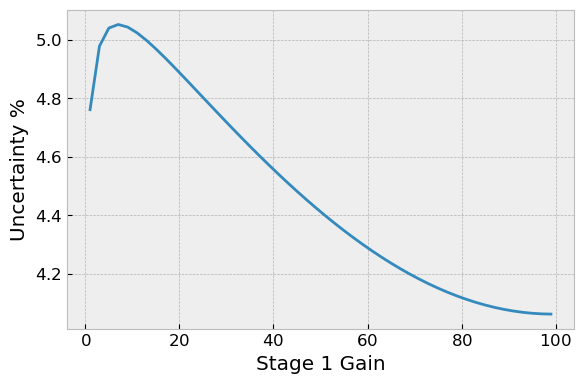

In [7]:
plt.plot(A1list, percent_uncert*100, lw=2)
plt.xlabel('Stage 1 Gain')
plt.ylabel('Uncertainty %')
plt.tight_layout()